In [6]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive"

In [7]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:

!kaggle datasets download -d arjuntejaswi/plant-village

100% 328M/329M [00:02<00:00, 134MB/s]
100% 329M/329M [00:02<00:00, 137MB/s]


In [10]:
!unzip plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

In [11]:
%rm -rf /content/PlantVillage/.ipynb_checkpoints

%rm -rf /content/PlantVillage/Pepper__bell___Bacterial_spot
%rm -rf /content/PlantVillage/Pepper__bell___healthy
%rm -rf /content/PlantVillage/Tomato_Bacterial_spot
%rm -rf /content/PlantVillage/Tomato_Leaf_Mold
%rm -rf /content/PlantVillage/Tomato_Septoria_leaf_spot
%rm -rf /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
%rm -rf /content/PlantVillage/Tomato__Target_Spot
%rm -rf /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus

%rm -rf /content/PlantVillage/Tomato__Tomato_mosaic_virus

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt


In [8]:
INPUT_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
n_classes = 6


In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (INPUT_SIZE,INPUT_SIZE),
    batch_size = BATCH_SIZE
)

NotFoundError: Could not find directory PlantVillage

In [13]:
class_names = dataset.class_names

NameError: name 'dataset' is not defined

In [16]:

class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

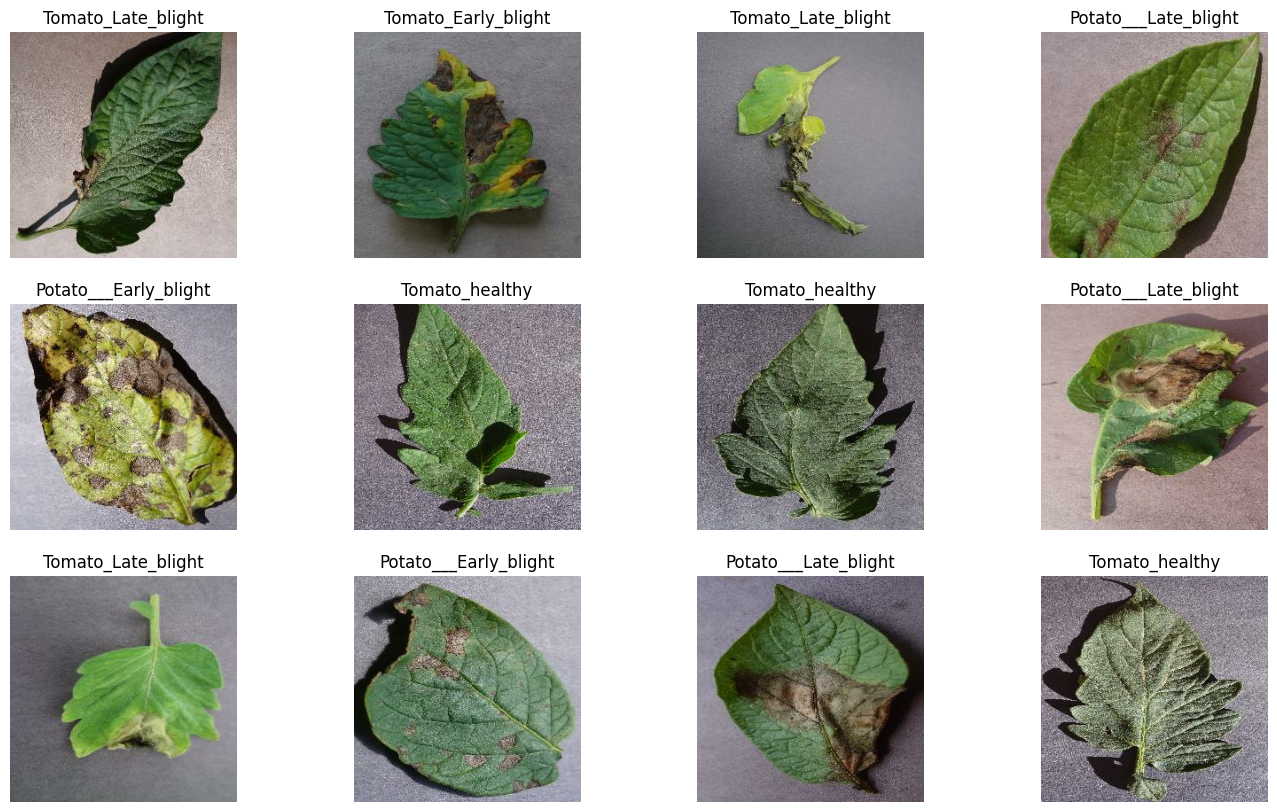

In [17]:
#visualitaion
plt.figure(figsize=(17,10))
for img_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    title = class_names[label_batch[i]]
    plt.title(title)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
#splitting data into training and testing sets
#trainning = 80%
#validation = 10%
#testing = 10%

def get_dataset_partions(ds,train_split=0.8,test_size=0.1,validation_size=0.1,shuffle=True,shuffle_size = 10000):
  le = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=True)
  train_size = int(le*train_split)
  train_set = ds.take(train_size)
  test_set = ds.skip(train_size)
  vaildation_size = int(le*test_size)
  validation_set = test_set.take(vaildation_size)
  test_set = test_set.skip(vaildation_size)
  return train_set,validation_set,test_set

In [19]:
train_set,validation_set,test_set = get_dataset_partions(dataset)


In [20]:

len(train_set)

166

In [21]:

len(test_set)

22

In [22]:
len(validation_set)


20

In [23]:
#optimizing dataset performance using cache and prefetch functions
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
#Creating resize and scaling layers
resize_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(INPUT_SIZE,INPUT_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
#creating layers to encounter rotated images
data_augementation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [26]:
input_shape = (BATCH_SIZE,INPUT_SIZE,INPUT_SIZE,CHANNELS)
model = models.Sequential([
    resize_rescale,
    data_augementation,
    layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_shape)

In [27]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


In [29]:
%%time
result = model.fit(
    train_set,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = validation_set
)


Epoch 1/10
166/166 [==============================] - 947s 6s/step - loss: 1.2264 - accuracy: 0.5145 - val_loss: 0.7879 - val_accuracy: 0.7031
Epoch 2/10
166/166 [==============================] - 873s 5s/step - loss: 0.7418 - accuracy: 0.7151 - val_loss: 0.7427 - val_accuracy: 0.7078
Epoch 3/10
166/166 [==============================] - 852s 5s/step - loss: 0.6457 - accuracy: 0.7570 - val_loss: 0.6590 - val_accuracy: 0.7609
Epoch 4/10
166/166 [==============================] - 853s 5s/step - loss: 0.5749 - accuracy: 0.7818 - val_loss: 0.6533 - val_accuracy: 0.7578
Epoch 5/10
 18/166 [==>...........................] - ETA: 12:04 - loss: 0.4814 - accuracy: 0.8160

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/execution.py", line 1335, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 926, in _call
    return self._no_variable_creation_fn(*arg

TypeError: object of type 'NoneType' has no len()

In [30]:
score=model.evaluate(test_set)

22/22 [==============================] - 44s 1s/step - loss: 0.6027 - accuracy: 0.7741


In [31]:
result.history['accuracy']

NameError: name 'result' is not defined

In [ ]:
acc=result.history['accuracy']
val_acc=result.history['val_accuracy']

loss=result.history['loss']
val_loss=result.history['val_loss']


NameError: name 'acc' is not defined

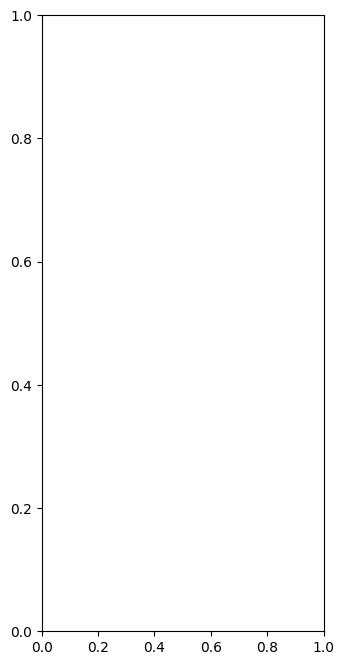

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),acc,label="Training Accuracy")
plt.plot(range(10),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training And Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(10),loss,label="Training Loss")
plt.plot(range(10),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training And Validation Loss")

In [33]:
model.save("/content/drive/MyDrive/dl_model/leaf_disease_model_model.h5")

In [16]:
import numpy as np
lis = []
for image_batch,label_batch in test_set.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch,verbose=1)
  output = class_names[np.argmax(batch_prediction[0])]
  lis.append(output)
  print("predicted label:",output)
  # print("predicted label:",class_names[np.argmax(batch_prediction[0])])


NameError: name 'test_set' is not defined

In [6]:
from keras.models import load_model
model = tf.keras.models.load_model('/content/drive/MyDrive/dl_model/leaf_disease_model_model.h5')

In [18]:
class_names = ['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']
import numpy as np

In [32]:
def predict(model, img_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(INPUT_SIZE, INPUT_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions using the model
    predictions = model.predict(img_array)

    # Get predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

# Provide the correct file path to the image

img_path = "/content/tomato_healthy.jpg"
predicted_class, confidence = predict(model, img_path)

print("Predicted Class:", predicted_class)
print("Confidence:", confidence, "%")


1/1 [==============================] - 0s 51ms/step
Predicted Class: Tomato_Late_blight
Confidence: 60.5 %


In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


NameError: name 'test_set' is not defined

<Figure size 1500x1500 with 0 Axes>

In [26]:
print(lis)

[]


In [29]:
pesticides = {'Potato___Early_blight':'Agrizeb','Potato___Late_blight':'Lycomax','Tomato_Early_blight':'Chlorothalonil.','Tomato_Late_blight':'Metalaxyl-M','Tomato_healthy':'Healthy','Potato___healthy':'Healthy'}
# for i in lis:
#   if i not in "healthy":
#     print("The best pesticide for the diesease ",i,"is ",pesticides[i])
#   else:
#     print("Healthy")
print(predicted_class,"-",pesticides[predicted_class])

Tomato_Late_blight - Metalaxyl-M
